# Setup and Data Preparation


In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For machine learning strategy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load your data
# df = pd.read_csv('datasets/ICLN.csv')
df = pd.read_csv('ICLN_data.csv')

# Calculate percentage change
df['Change_Percentage'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

# Reset index for sequential data
df = df.reset_index()

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

df.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close_Lag1', 'Open_Lag1', 'High_Lag1', 'Low_Lag1', 'SMA_5', 'SMA_10',
       'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'MOM_10',
       'close_0C2_constituent', 'close_600900_constituent',
       'close_ED_constituent', 'close_ENPH_constituent',
       'close_FSLR_constituent', 'close_ORSTED_constituent',
       'close_VWS_constituent', 'close_^IBEX_constituent', 'close_XLI_etf',
       'close_XLK_etf', 'close_XLU_etf', 'Change_Percentage'],
      dtype='object')

In [249]:
print('Train:')
print(f'Start date: {train_df.Date.min()}')
print(f'Start date: {train_df.Date.max()}')
print(f'Period length: {len(pd.date_range(start=train_df.Date.min(), end=train_df.Date.max()))} days\n')
print('Test:')
print(f'Start date: {test_df.Date.min()}')
print(f'Start date: {test_df.Date.max()}')
print(f'Period length: {len(pd.date_range(start=test_df.Date.min(), end=test_df.Date.max()))} days\n')


Train:
Start date: 2017-08-29
Start date: 2023-02-16
Period length: 1998 days

Test:
Start date: 2023-02-17
Start date: 2024-07-08
Period length: 508 days



# Implementing the Strategies


## Moving Average Crossover Strategy


In [210]:
# # Calculate moving averages
# df['MA_Short'] = df['Close'].rolling(window=10).mean()
# df['MA_Long'] = df['Close'].rolling(window=50).mean()

# # Generate signals
# df['Signal_MACrossover'] = 0
# df['Signal_MACrossover'] = np.where(df['MA_Short'] > df['MA_Long'], 1, -1)

# # Use only the test data
# test_df['Signal_MACrossover'] = df['Signal_MACrossover'].iloc[train_size:].values

# # Simulate trades
# test_df['Return_MACrossover'] = test_df['Signal_MACrossover'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [211]:
# Calculate moving averages
df['MA_Short'] = df['Close'].rolling(window=10).mean()
df['MA_Long'] = df['Close'].rolling(window=50).mean()

# Use only the test data
test_df['MA_Short'] = df['MA_Short'].iloc[train_size:].values
test_df['MA_Long'] = df['MA_Long'].iloc[train_size:].values

# Define buffer
buffer = 0.1  # Buffer of 0.1 units (adjust as needed)

# Calculate difference
test_df['MA_Diff'] = test_df['MA_Short'] - test_df['MA_Long']

# Generate signals
test_df['Signal_MACrossover'] = 0
test_df.loc[test_df['MA_Diff'] > buffer, 'Signal_MACrossover'] = 1
test_df.loc[test_df['MA_Diff'] < -buffer, 'Signal_MACrossover'] = -1

# Simulate trades
test_df['Return_MACrossover'] = test_df['Signal_MACrossover'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Momentum-Based Trading Strategy

In [212]:
# # Replace this with your actual model predictions
# test_df['Predicted_Change'] = test_df['Close'].rolling(window=5).mean().pct_change() * 100
# test_df['Predicted_Change'].fillna(0, inplace=True)

# # Generate signals based on predicted change
# test_df['Signal_Momentum'] = np.where(test_df['Predicted_Change'] > 0, 1, -1)

# # Simulate trades
# test_df['Return_Momentum'] = test_df['Signal_Momentum'] * (test_df['Close'] - test_df['Open']) / test_df['Open']

In [213]:
# Replace this with your actual model predictions
test_df['Predicted_Change'] = test_df['Close'].rolling(window=5).mean().pct_change() * 100
test_df['Predicted_Change'].fillna(0, inplace=True)

# Define thresholds
threshold_buy = 0.5  # 0.5% predicted increase
threshold_sell = -0.5  # -0.5% predicted decrease

# Generate signals
test_df['Signal_Momentum'] = 0  # Default to do nothing
test_df.loc[test_df['Predicted_Change'] > threshold_buy, 'Signal_Momentum'] = 1
test_df.loc[test_df['Predicted_Change'] < threshold_sell, 'Signal_Momentum'] = -1

# Simulate trades
test_df['Return_Momentum'] = test_df['Signal_Momentum'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Bollinger Bands Strategy

In [214]:
# # Calculate Bollinger Bands
# df['MA20'] = df['Close'].rolling(window=20).mean()
# df['STD20'] = df['Close'].rolling(window=20).std()
# df['Upper_Band'] = df['MA20'] + (df['STD20'] * 2)
# df['Lower_Band'] = df['MA20'] - (df['STD20'] * 2)

# # Generate signals
# df['Signal_Bollinger'] = 0
# df['Signal_Bollinger'] = np.where(df['Close'] < df['Lower_Band'], 1, df['Signal_Bollinger'])
# df['Signal_Bollinger'] = np.where(df['Close'] > df['Upper_Band'], -1, df['Signal_Bollinger'])

# # Use only the test data
# test_df['Signal_Bollinger'] = df['Signal_Bollinger'].iloc[train_size:].values

# # Simulate trades
# test_df['Return_Bollinger'] = test_df['Signal_Bollinger'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [215]:
# Calculate Bollinger Bands
df['MA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['STD20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['STD20'] * 2)

# Use only the test data
test_df['MA20'] = df['MA20'].iloc[train_size:].values
test_df['Upper_Band'] = df['Upper_Band'].iloc[train_size:].values
test_df['Lower_Band'] = df['Lower_Band'].iloc[train_size:].values

# Define band margin
band_margin = 0.01  # 1% margin

# Generate signals
test_df['Signal_Bollinger'] = 0
test_df.loc[test_df['Close'] < test_df['Lower_Band'] * (1 - band_margin), 'Signal_Bollinger'] = 1
test_df.loc[test_df['Close'] > test_df['Upper_Band'] * (1 + band_margin), 'Signal_Bollinger'] = -1

# Simulate trades
test_df['Return_Bollinger'] = test_df['Signal_Bollinger'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Mean Reversion Strategy

In [216]:
# # Calculate moving average and difference
# df['MA20'] = df['Close'].rolling(window=20).mean()
# df['Price_MA20_Diff'] = df['Close'] - df['MA20']

# # Use only the test data
# test_df['MA20'] = df['MA20'].iloc[train_size:].values
# test_df['Price_MA20_Diff'] = df['Price_MA20_Diff'].iloc[train_size:].values

# # Define threshold
# threshold = test_df['Price_MA20_Diff'].std()

# # Generate signals
# test_df['Signal_MeanReversion'] = 0
# test_df.loc[test_df['Price_MA20_Diff'] < -threshold, 'Signal_MeanReversion'] = 1  # Buy
# test_df.loc[test_df['Price_MA20_Diff'] > threshold, 'Signal_MeanReversion'] = -1  # Sell

# # Simulate trades
# test_df['Return_MeanReversion'] = test_df['Signal_MeanReversion'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [217]:
# Calculate moving average and standard deviation
df['MA20'] = df['Close'].rolling(window=20).mean()
df['STD20'] = df['Close'].rolling(window=20).std()

# Use only the test data
test_df['MA20'] = df['MA20'].iloc[train_size:].values
test_df['STD20'] = df['STD20'].iloc[train_size:].values

# Define threshold
threshold = 1  # Number of standard deviations

# Calculate z-score (number of standard deviations from MA)
test_df['Z_Score'] = (test_df['Close'] - test_df['MA20']) / test_df['STD20']

# Generate signals
test_df['Signal_MeanReversion'] = 0
test_df.loc[test_df['Z_Score'] < -threshold, 'Signal_MeanReversion'] = 1  # Buy
test_df.loc[test_df['Z_Score'] > threshold, 'Signal_MeanReversion'] = -1  # Sell

# Simulate trades
test_df['Return_MeanReversion'] = test_df['Signal_MeanReversion'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## RSI Overbought/Oversold Strategy

In [218]:
# # Calculate RSI (reuse the previous RSI calculation)
# def calculate_RSI(series, period=14):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).fillna(0)
#     loss = (-delta.where(delta < 0, 0)).fillna(0)
#     avg_gain = gain.rolling(window=period).mean()
#     avg_loss = loss.rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi

# df['RSI'] = calculate_RSI(df['Close'])

# # Generate signals
# df['Signal_RSI'] = 0
# df['Signal_RSI'] = np.where(df['RSI'] < 30, 1, df['Signal_RSI'])  # Buy
# df['Signal_RSI'] = np.where(df['RSI'] > 70, -1, df['Signal_RSI'])  # Sell

# # Use only the test data
# test_df['Signal_RSI'] = df['Signal_RSI'].iloc[train_size:].values

# # Simulate trades
# test_df['Return_RSI'] = test_df['Signal_RSI'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [219]:
# Calculate RSI
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_RSI(df['Close'])

# Use only the test data
test_df['RSI'] = df['RSI'].iloc[train_size:].values

# Define thresholds
oversold_threshold = 25
overbought_threshold = 75

# Generate signals
test_df['Signal_RSI'] = 0
test_df.loc[test_df['RSI'] < oversold_threshold, 'Signal_RSI'] = 1
test_df.loc[test_df['RSI'] > overbought_threshold, 'Signal_RSI'] = -1

# Simulate trades
test_df['Return_RSI'] = test_df['Signal_RSI'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Combined Strategy with Predictive Model and Technical Indicators

In [220]:
# # Calculate RSI
# def calculate_RSI(series, period=14):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).fillna(0)
#     loss = (-delta.where(delta < 0, 0)).fillna(0)
#     avg_gain = gain.rolling(window=period).mean()
#     avg_loss = loss.rolling(window=period).mean()
#     rs = avg_gain / avg_loss
#     rsi = 100 - (100 / (1 + rs))
#     return rsi

# df['RSI'] = calculate_RSI(df['Close'])

# # Calculate MACD
# df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
# df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
# df['MACD'] = df['EMA12'] - df['EMA26']
# df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# # Prepare test data
# test_df['RSI'] = df['RSI'].iloc[train_size:].values
# test_df['MACD'] = df['MACD'].iloc[train_size:].values
# test_df['Signal_Line'] = df['Signal_Line'].iloc[train_size:].values

# # Generate signals
# test_df['Signal_Combined'] = 0
# buy_conditions = (
#     (test_df['Predicted_Change'] > 0) &
#     (test_df['RSI'] < 30) &
#     (test_df['MACD'] > test_df['Signal_Line'])
# )
# sell_conditions = (
#     (test_df['Predicted_Change'] < 0) &
#     (test_df['RSI'] > 70) &
#     (test_df['MACD'] < test_df['Signal_Line'])
# )

# test_df.loc[buy_conditions, 'Signal_Combined'] = 1
# test_df.loc[sell_conditions, 'Signal_Combined'] = -1

# # Simulate trades
# test_df['Return_Combined'] = test_df['Signal_Combined'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [221]:
# Calculate RSI
def calculate_RSI(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_RSI(df['Close'])

# Calculate MACD
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Prepare test data
test_df['RSI'] = df['RSI'].iloc[train_size:].values
test_df['MACD'] = df['MACD'].iloc[train_size:].values
test_df['Signal_Line'] = df['Signal_Line'].iloc[train_size:].values


In [222]:
# Generate signals
test_df['Signal_Combined'] = 0

# Buy condition
buy_conditions = (
    (test_df['Predicted_Change'] > threshold_buy) &  # Use thresholds similar to momentum strategy
    (test_df['RSI'] < 30) &
    (test_df['MACD'] > test_df['Signal_Line'])
)

# Sell condition
sell_conditions = (
    (test_df['Predicted_Change'] < threshold_sell) &
    (test_df['RSI'] > 70) &
    (test_df['MACD'] < test_df['Signal_Line'])
)

test_df.loc[buy_conditions, 'Signal_Combined'] = 1
test_df.loc[sell_conditions, 'Signal_Combined'] = -1

# Simulate trades
test_df['Return_Combined'] = test_df['Signal_Combined'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Breakout Strategy

In [223]:
# # Calculate rolling high and low
# df['Rolling_Max'] = df['High'].rolling(window=20).max()
# df['Rolling_Min'] = df['Low'].rolling(window=20).min()

# # Generate signals
# df['Signal_Breakout'] = 0
# df['Signal_Breakout'] = np.where(df['Close'] > df['Rolling_Max'].shift(1), 1, df['Signal_Breakout'])  # Breakout above resistance
# df['Signal_Breakout'] = np.where(df['Close'] < df['Rolling_Min'].shift(1), -1, df['Signal_Breakout'])  # Breakout below support

# # Use only the test data
# test_df['Signal_Breakout'] = df['Signal_Breakout'].iloc[train_size:].values

# # Simulate trades
# test_df['Return_Breakout'] = test_df['Signal_Breakout'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [224]:
# Calculate rolling high and low
df['Rolling_Max'] = df['High'].rolling(window=20).max()
df['Rolling_Min'] = df['Low'].rolling(window=20).min()

# Use only the test data
test_df['Rolling_Max'] = df['Rolling_Max'].iloc[train_size:].values
test_df['Rolling_Min'] = df['Rolling_Min'].iloc[train_size:].values

# Define breakout margin
breakout_margin = 0.01  # 1% margin

# Generate signals
test_df['Signal_Breakout'] = 0
test_df.loc[test_df['Close'] > test_df['Rolling_Max'].shift(1) * (1 + breakout_margin), 'Signal_Breakout'] = 1
test_df.loc[test_df['Close'] < test_df['Rolling_Min'].shift(1) * (1 - breakout_margin), 'Signal_Breakout'] = -1

# Simulate trades
test_df['Return_Breakout'] = test_df['Signal_Breakout'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## MACD Crossover Strategy

In [225]:
# Use only the test data
test_df['MACD'] = df['MACD'].iloc[train_size:].values
test_df['Signal_Line'] = df['Signal_Line'].iloc[train_size:].values

# Define MACD threshold
macd_threshold = 0.1  # Adjust based on data scale

# Calculate MACD difference
test_df['MACD_Diff'] = test_df['MACD'] - test_df['Signal_Line']

# Generate signals
test_df['Signal_MACD'] = 0
test_df.loc[(test_df['MACD_Diff'] > macd_threshold) & (test_df['MACD_Diff'].shift(1) <= macd_threshold), 'Signal_MACD'] = 1
test_df.loc[(test_df['MACD_Diff'] < -macd_threshold) & (test_df['MACD_Diff'].shift(1) >= -macd_threshold), 'Signal_MACD'] = -1

# Simulate trades
test_df['Return_MACD'] = test_df['Signal_MACD'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


## Machine Learning / Deep Learning Strategy

### Random Forest Classifier

In [226]:
# # Prepare labels
# df['Future_Return'] = df['Close'].shift(-1) - df['Close']
# df['Label'] = np.where(df['Future_Return'] > 0, 1, 0)

# # Prepare features
# features = ['RSI', 'MACD', 'Volume']
# df['RSI'] = df['RSI'].fillna(method='bfill')
# df['MACD'] = df['MACD'].fillna(method='bfill')
# df['Volume'] = df['Volume'].fillna(method='bfill')

# # Split data
# X = df[features]
# y = df['Label']

# X_train_rf = X.iloc[:train_size]
# y_train_rf = y.iloc[:train_size]
# X_test_rf = X.iloc[train_size:]
# y_test_rf = y.iloc[train_size:]

# # Train Random Forest Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train_rf, y_train_rf)

# # Make predictions
# test_df['Signal_RF'] = clf.predict(X_test_rf)

# # Adjust signals to -1 and 1
# test_df['Signal_RF'] = test_df['Signal_RF'].replace(0, -1)

# # Simulate trades
# test_df['Return_RF'] = test_df['Signal_RF'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [227]:
# Prepare labels
df['Future_Return'] = df['Close'].shift(-1) - df['Close']
df['Label'] = np.where(df['Future_Return'] > 0, 1, 0)

# Prepare features
features = ['RSI', 'MACD', 'Volume']
df['RSI'] = df['RSI'].fillna(method='bfill')
df['MACD'] = df['MACD'].fillna(method='bfill')
df['Volume'] = df['Volume'].fillna(method='bfill')

# Split data
X = df[features]
y = df['Label']

X_train_rf = X.iloc[:train_size]
y_train_rf = y.iloc[:train_size]
X_test_rf = X.iloc[train_size:]
y_test_rf = y.iloc[train_size:]

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_rf, y_train_rf)

# Set probability threshold
prob_threshold = 0.6  # 60% confidence

# Make predictions with probabilities
y_pred_prob = clf.predict_proba(X_test_rf)

# Initialize signals
test_df['Signal_RF'] = 0

# Generate signals based on probabilities
test_df.loc[y_pred_prob[:, 1] > prob_threshold, 'Signal_RF'] = 1  # Probability of class 1 (price goes up)
test_df.loc[y_pred_prob[:, 0] > prob_threshold, 'Signal_RF'] = -1  # Probability of class 0 (price goes down)

# Simulate trades
test_df['Return_RF'] = test_df['Signal_RF'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


### XGBoost

In [228]:
# import xgboost as xgb

# # Split data
# X_train_xgb = X.iloc[:train_size]
# y_train_xgb = y[:train_size]
# X_test_xgb = X.iloc[train_size:]
# y_test_xgb = y[train_size:]

# # Create DMatrix for XGBoost
# dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
# dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# # Set parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'seed': 42
# }

# # Train the model
# xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# # Make predictions
# y_pred_prob = xgb_model.predict(dtest)
# y_pred_xgb = np.where(y_pred_prob > 0.5, 1, -1)  # Convert probabilities to -1 or 1

# # Store signals and returns in test_df
# test_df['Signal_XGBoost'] = y_pred_xgb
# test_df['Return_XGBoost'] = test_df['Signal_XGBoost'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [229]:
import xgboost as xgb

# Split data
X_train_xgb = X.iloc[:train_size]
y_train_xgb = y[:train_size]
X_test_xgb = X.iloc[train_size:]
y_test_xgb = y[train_size:]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train the model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions with probabilities
y_pred_prob = xgb_model.predict(dtest)

# Initialize signals
test_df['Signal_XGBoost'] = 0

# Generate signals based on probability threshold
prob_threshold = 0.6  # 60% confidence

test_df.loc[y_pred_prob > prob_threshold, 'Signal_XGBoost'] = 1
test_df.loc[y_pred_prob < (1 - prob_threshold), 'Signal_XGBoost'] = -1

# Simulate trades
test_df['Return_XGBoost'] = test_df['Signal_XGBoost'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


### Long Short-Term Memory (LSTM)

Regression LSTM

In [232]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define your features list
features_list = ['Close', 'High', 'Low', 'Open', 'Adj Close', 'Volume',
                 'Close_Lag1', 'Open_Lag1', 'High_Lag1', 'Low_Lag1', 'SMA_5', 'SMA_10',
                 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'MOM_10',
                 'close_0C2_constituent', 'close_600900_constituent',
                 'close_ED_constituent', 'close_ENPH_constituent',
                 'close_FSLR_constituent', 'close_ORSTED_constituent',
                 'close_VWS_constituent', 'close_^IBEX_constituent', 'close_XLI_etf',
                 'close_XLK_etf', 'close_XLU_etf']

# Ensure all features are in df
missing_features = [feat for feat in features_list if feat not in df.columns]
if missing_features:
    print(f"The following features are missing in df: {missing_features}")

# Drop rows with missing values in the selected features
df = df.dropna(subset=features_list)

# Recalculate train_size based on the new df length
train_size = int(len(df) * 0.8)

# Prepare data
sequence_length = 10  # Number of past time steps to use

# Extract features and target
lstm_features = df[features_list].values
lstm_target = df['Close'].values  # Assuming we are predicting the Close price

# Scale features
scaler = StandardScaler()
lstm_features_scaled = scaler.fit_transform(lstm_features)

# Create sequences
def create_sequences(features, target, seq_length):
    xs = []
    ys = []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(lstm_features_scaled, lstm_target, sequence_length)

# Split data
X_train_lstm = X_lstm[:train_size - sequence_length]
y_train_lstm = y_lstm[:train_size - sequence_length]
X_test_lstm = X_lstm[train_size - sequence_length:]
y_test_lstm = y_lstm[train_size - sequence_length:]

# Convert to tensors
X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_lstm = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_lstm = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_lstm = torch.tensor(y_test_lstm, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Define LSTM Model
class LSTMStrategy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMStrategy, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn[-1]
        out = self.fc(hn)
        return out

input_size = X_train_lstm.shape[2]
hidden_size = 64
num_layers = 2

model_lstm = LSTMStrategy(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model_lstm.eval()
with torch.no_grad():
    y_pred_lstm = model_lstm(X_test_lstm)

# Convert predictions to numpy
y_pred_lstm_np = y_pred_lstm.numpy().squeeze()

# Prepare test_df
test_df_lstm = df.iloc[train_size:].reset_index(drop=True)
test_df_lstm = test_df_lstm.iloc[:len(y_pred_lstm_np)] 

# Generate signals
test_df_lstm['Predicted_Price_LSTM'] = y_pred_lstm_np
test_df_lstm['Signal_LSTM'] = 0

# Define thresholds
threshold_buy = 100  # 0.5% predicted increase
threshold_sell = -100  # -0.5% predicted decrease

# Calculate predicted change percentage
test_df_lstm['Predicted_Change_LSTM'] = (test_df_lstm['Predicted_Price_LSTM'] - test_df_lstm['Close']) / test_df_lstm['Close'] * 100

# Generate signals
test_df_lstm.loc[test_df_lstm['Predicted_Change_LSTM'] > threshold_buy, 'Signal_LSTM'] = 1
test_df_lstm.loc[test_df_lstm['Predicted_Change_LSTM'] < threshold_sell, 'Signal_LSTM'] = -1

# Simulate trades
test_df_lstm['Open_Price'] = test_df_lstm['Open']
test_df_lstm['Close_Price'] = test_df_lstm['Close']
test_df_lstm['Return_LSTM'] = test_df_lstm['Signal_LSTM'] * (test_df_lstm['Close_Price'] - test_df_lstm['Open_Price']) / test_df_lstm['Open_Price']


LSTM Epoch [10/100], Loss: 16.5331
LSTM Epoch [20/100], Loss: 0.4140
LSTM Epoch [30/100], Loss: 0.1406
LSTM Epoch [40/100], Loss: 0.2007
LSTM Epoch [50/100], Loss: 0.1488
LSTM Epoch [60/100], Loss: 0.1828
LSTM Epoch [70/100], Loss: 0.1990
LSTM Epoch [80/100], Loss: 0.1726
LSTM Epoch [90/100], Loss: 0.1610
LSTM Epoch [100/100], Loss: 0.1773


Classification LSTM

In [291]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Define your features list
features_list = ['Close', 'High', 'Low', 'Open', 'Adj Close', 'Volume',
                 'Close_Lag1', 'Open_Lag1', 'High_Lag1', 'Low_Lag1', 'SMA_5', 'SMA_10',
                 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'MOM_10',
                 'close_0C2_constituent', 'close_600900_constituent',
                 'close_ED_constituent', 'close_ENPH_constituent',
                 'close_FSLR_constituent', 'close_ORSTED_constituent',
                 'close_VWS_constituent', 'close_^IBEX_constituent', 'close_XLI_etf',
                 'close_XLK_etf', 'close_XLU_etf']

# Ensure all features are in df
missing_features = [feat for feat in features_list if feat not in df.columns]
if missing_features:
    print(f"The following features are missing in df: {missing_features}")

# Drop rows with missing values in the selected features
df = df.dropna(subset=features_list)

# Define thresholds for classification
threshold_sell = -1  # -1% predicted decrease
threshold_buy = 1    # 1% predicted increase

# Calculate future returns
df['Future_Return'] = df['Close'].shift(-1) / df['Close'] - 1

# Drop the last row as it will have NaN for Future_Return
df = df[:-1]

# Create classification labels
def classify_return(x):
    if x > threshold_buy / 100:
        return 2  # Buy
    elif x < threshold_sell / 100:
        return 0  # Sell
    else:
        return 1  # Hold

df['Signal'] = df['Future_Return'].apply(classify_return)

# Recalculate train_size based on the new df length
train_size = int(len(df) * 0.8)

# Prepare data
sequence_length = 10  # Number of past time steps to use

# Extract features and labels
lstm_features = df[features_list].values
lstm_labels = df['Signal'].values

# Scale features
scaler = StandardScaler()
lstm_features_scaled = scaler.fit_transform(lstm_features)

# Create sequences
def create_sequences(features, labels, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length), :]
        y = labels[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_lstm, y_lstm = create_sequences(lstm_features_scaled, lstm_labels, sequence_length)

# Split data
X_train_lstm = X_lstm[:train_size - sequence_length]
y_train_lstm = y_lstm[:train_size - sequence_length]
X_test_lstm = X_lstm[train_size - sequence_length:]
y_test_lstm = y_lstm[train_size - sequence_length:]

# Convert to tensors
X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_lstm = torch.tensor(y_train_lstm, dtype=torch.long)
X_test_lstm = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_lstm = torch.tensor(y_test_lstm, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define LSTM Model for Classification
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn[-1]
        out = self.fc(hn)
        return out

input_size = X_train_lstm.shape[2]
hidden_size = 64
num_layers = 2
num_classes = 3

model_lstm = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)
class_counts = df['Signal'].value_counts()
class_sum = class_counts.sum()
# class_weights = torch.tensor([float(class_counts[0] / class_sum), 
#                               float(class_counts[1] / class_sum), 
#                               float(class_counts[2] / class_sum)])  # Weights for Sell, Hold, Buy
class_weights = torch.tensor([1.0, 1.5, 1.0])  # Weights for Sell, Hold, Buy
criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model_lstm.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Make predictions
model_lstm.eval()
with torch.no_grad():
    outputs = model_lstm(X_test_lstm)
    _, predicted = torch.max(outputs, 1)

# Convert predictions to numpy
y_pred_lstm_np = predicted.numpy().squeeze()

# Ensure test_df_lstm matches the length of y_test_lstm and predicted
test_df_lstm = df.iloc[train_size:].reset_index(drop=True)
test_df_lstm = test_df_lstm.iloc[:len(y_pred_lstm_np)] 

# Add predicted signals
test_df_lstm['Predicted_Signal_LSTM'] = predicted.numpy()

# Map class labels to signals (-1, 0, 1)
signal_mapping = {0: -1, 1: 0, 2: 1}
test_df_lstm['Signal_LSTM'] = test_df_lstm['Predicted_Signal_LSTM'].map(signal_mapping)

# Simulate trades
test_df_lstm['Open_Price'] = test_df_lstm['Open']
test_df_lstm['Close_Price'] = test_df_lstm['Close']
test_df_lstm['Return_LSTM'] = test_df_lstm['Signal_LSTM'] * (test_df_lstm['Close_Price'] - test_df_lstm['Open_Price']) / test_df_lstm['Open_Price']

# Calculate cumulative returns
test_df_lstm['Cumulative_Return_LSTM'] = (1 + test_df_lstm['Return_LSTM']).cumprod() - 1

# Evaluate performance
accuracy = (test_df_lstm['Predicted_Signal_LSTM'] == test_df_lstm['Signal']).mean()
print(f'Classification Accuracy: {accuracy:.2%}')

print(classification_report(test_df_lstm['Signal'], test_df_lstm['Predicted_Signal_LSTM'], target_names=['Sell', 'Hold', 'Buy']))

LSTM Epoch [10/200], Loss: 0.8447
LSTM Epoch [20/200], Loss: 0.8189
LSTM Epoch [30/200], Loss: 0.7934
LSTM Epoch [40/200], Loss: 0.7654
LSTM Epoch [50/200], Loss: 0.7237
LSTM Epoch [60/200], Loss: 0.6720
LSTM Epoch [70/200], Loss: 0.6082
LSTM Epoch [80/200], Loss: 0.5338
LSTM Epoch [90/200], Loss: 0.4679
LSTM Epoch [100/200], Loss: 0.4366
LSTM Epoch [110/200], Loss: 0.3681
LSTM Epoch [120/200], Loss: 0.3448
LSTM Epoch [130/200], Loss: 0.3562
LSTM Epoch [140/200], Loss: 0.2496
LSTM Epoch [150/200], Loss: 0.2282
LSTM Epoch [160/200], Loss: 0.3163
LSTM Epoch [170/200], Loss: 0.2216
LSTM Epoch [180/200], Loss: 0.1140
LSTM Epoch [190/200], Loss: 0.1475
LSTM Epoch [200/200], Loss: 0.1674
Classification Accuracy: 40.26%
              precision    recall  f1-score   support

        Sell       0.24      0.22      0.23        88
        Hold       0.47      0.68      0.56       146
         Buy       0.27      0.06      0.10        69

    accuracy                           0.40       303
   ma


Testing with Buy/Sell Threshold: ±0.1%
Threshold: 0.10, Accuracy: 53.77%, F1 Score: 0.2751

Testing with Buy/Sell Threshold: ±0.5%
Threshold: 0.50, Accuracy: 31.80%, F1 Score: 0.2560

Testing with Buy/Sell Threshold: ±0.9%
Threshold: 0.90, Accuracy: 45.07%, F1 Score: 0.2071

Testing with Buy/Sell Threshold: ±1.3000000000000003%
Threshold: 1.30, Accuracy: 60.20%, F1 Score: 0.2505

Testing with Buy/Sell Threshold: ±1.7000000000000002%
Threshold: 1.70, Accuracy: 74.67%, F1 Score: 0.2850


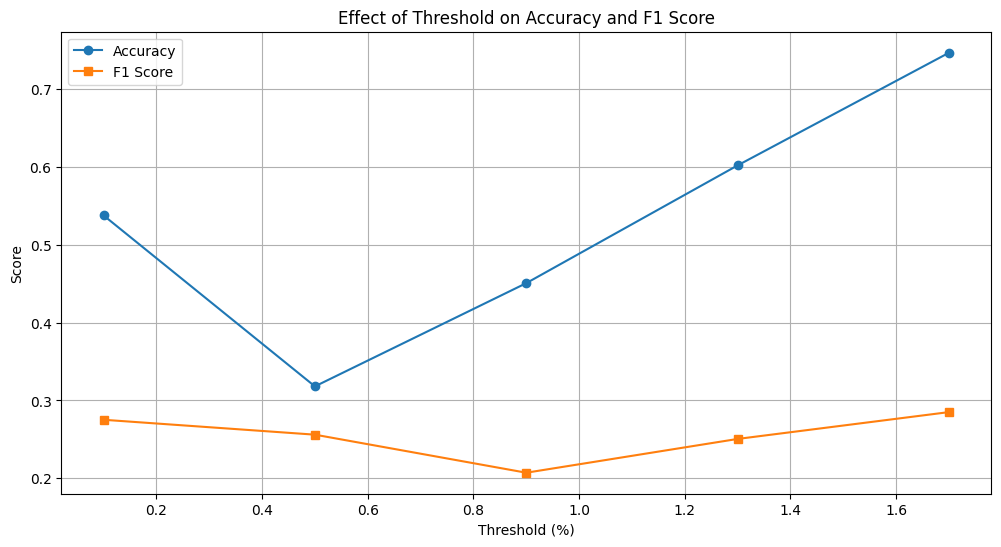

In [285]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Define your features list and ensure they exist in df
features_list = ['Close', 'High', 'Low', 'Open', 'Adj Close', 'Volume',
                 'Close_Lag1', 'Open_Lag1', 'High_Lag1', 'Low_Lag1', 'SMA_5', 'SMA_10',
                 'RSI_14', 'BB_middle', 'BB_std', 'BB_upper', 'BB_lower', 'MOM_10',
                 'close_0C2_constituent', 'close_600900_constituent', 'close_ED_constituent',
                 'close_ENPH_constituent', 'close_FSLR_constituent', 'close_ORSTED_constituent',
                 'close_VWS_constituent', 'close_^IBEX_constituent', 'close_XLI_etf',
                 'close_XLK_etf', 'close_XLU_etf']

# Ensure all features are in df
missing_features = [feat for feat in features_list if feat not in df.columns]
if missing_features:
    print(f"The following features are missing in df: {missing_features}")

# Drop rows with missing values in the selected features
df = df.dropna(subset=features_list)

# Threshold ranges to iterate over
threshold_ranges = np.arange(0.1, 2.1, 0.4)  # Test thresholds from 0.1% to 2.0%, in steps of 0.4%

results = []

for threshold in threshold_ranges:
    print(f"\nTesting with Buy/Sell Threshold: ±{threshold}%")

    # Define thresholds for classification
    threshold_sell = -threshold  # Dynamic threshold for sell
    threshold_buy = threshold    # Dynamic threshold for buy

    # Calculate future returns
    df['Future_Return'] = df['Close'].shift(-1) / df['Close'] - 1

    # Drop the last row as it will have NaN for Future_Return
    df = df[:-1]

    # Create classification labels
    def classify_return(x):
        if x > threshold_buy / 100:
            return 2  # Buy
        elif x < threshold_sell / 100:
            return 0  # Sell
        else:
            return 1  # Hold

    df['Signal'] = df['Future_Return'].apply(classify_return)

    # Recalculate train_size based on the new df length
    train_size = int(len(df) * 0.8)

    # Prepare data
    sequence_length = 10  # Number of past time steps to use

    # Extract features and labels
    lstm_features = df[features_list].values
    lstm_labels = df['Signal'].values

    # Scale features
    scaler = StandardScaler()
    lstm_features_scaled = scaler.fit_transform(lstm_features)

    # Create sequences
    def create_sequences(features, labels, seq_length):
        xs, ys = [], []
        for i in range(len(features) - seq_length):
            x = features[i:(i + seq_length), :]
            y = labels[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X_lstm, y_lstm = create_sequences(lstm_features_scaled, lstm_labels, sequence_length)

    # Split data
    X_train_lstm = X_lstm[:train_size - sequence_length]
    y_train_lstm = y_lstm[:train_size - sequence_length]
    X_test_lstm = X_lstm[train_size - sequence_length:]
    y_test_lstm = y_lstm[train_size - sequence_length:]

    # Convert to tensors
    X_train_lstm = torch.tensor(X_train_lstm, dtype=torch.float32)
    y_train_lstm = torch.tensor(y_train_lstm, dtype=torch.long)
    X_test_lstm = torch.tensor(X_test_lstm, dtype=torch.float32)
    y_test_lstm = torch.tensor(y_test_lstm, dtype=torch.long)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Define LSTM Model for Classification
    class LSTMClassifier(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(LSTMClassifier, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c_0 = torch.zeros(num_layers, x.size(0), hidden_size)
            output, (hn, cn) = self.lstm(x, (h_0, c_0))
            hn = hn[-1]
            out = self.fc(hn)
            return out

    # Define LSTM Model with Increased Complexity
    class DeepLSTMClassifier(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(DeepLSTMClassifier, self).__init__()
            # Stack multiple LSTM layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, 
                                bidirectional=True, dropout=0.3)
            
            # Fully connected layers after LSTM
            self.fc1 = nn.Linear(hidden_size * 2, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, num_classes)

            # Activation functions and dropout
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.3)

        def forward(self, x):
            # Initialize hidden and cell states
            h_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size)  # num_layers * 2 for bidirectional
            c_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size)

            # Forward propagate LSTM
            output, (hn, cn) = self.lstm(x, (h_0, c_0))
            # Concatenate the hidden states from both directions
            hn = hn.view(num_layers, 2, x.size(0), hidden_size)[-1]
            hn = torch.cat((hn[0], hn[1]), dim=1)

            # Pass through fully connected layers with ReLU and Dropout
            x = self.fc1(hn)
            x = self.relu(x)
            x = self.dropout(x)

            x = self.fc2(x)
            x = self.relu(x)
            x = self.dropout(x)

            x = self.fc3(x)
            return x
        
        input_size = X_train_lstm.shape[2]
        hidden_size = 64
        num_layers = 2
        num_classes = 3

    model_lstm = DeepLSTMClassifier(input_size, hidden_size, num_layers, num_classes)

    # Adjust class weights
    class_weights = torch.tensor([1.0, 1.5, 1.0])  # Weights for Sell, Hold, Buy
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

    # Train the model
    num_epochs = 50  # Set to 50 for faster iteration through different thresholds
    for epoch in range(num_epochs):
        model_lstm.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model_lstm(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

    # Make predictions
    model_lstm.eval()
    with torch.no_grad():
        outputs = model_lstm(X_test_lstm)
        _, predicted = torch.max(outputs, 1)

    # Convert predictions to numpy
    y_pred_lstm_np = predicted.numpy().squeeze()

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_lstm, y_pred_lstm_np)
    f1 = f1_score(y_test_lstm, y_pred_lstm_np, average='macro')

    # Store the results
    results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'F1_Score': f1
    })

    # Print the results for this threshold
    print(f'Threshold: {threshold:.2f}, Accuracy: {accuracy:.2%}, F1 Score: {f1:.4f}')

# Create a DataFrame of results
results_df = pd.DataFrame(results)

# Plot the results to visualize the impact of thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['Threshold'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['Threshold'], results_df['F1_Score'], marker='s', label='F1 Score')
plt.xlabel('Threshold (%)')
plt.ylabel('Score')
plt.title('Effect of Threshold on Accuracy and F1 Score')
plt.legend()
plt.grid()
plt.show()


### Gated Recurrent Units (GRU)

In [233]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Define input_size based on the number of features used for the GRU model
input_size = 3  # Number of features: 'Close', 'RSI', 'MACD'
hidden_size = 64
num_layers = 2

# Prepare data (from earlier steps)
sequence_length = 10

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :]
        y = data[i + seq_length, -1]  # Close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Features: ['Close', 'RSI', 'MACD']
gru_features = df[['Close', 'RSI', 'MACD']].values
scaler_gru = StandardScaler()
gru_features_scaled = scaler_gru.fit_transform(gru_features)

# Create sequences for training and testing
X_gru, y_gru = create_sequences(gru_features_scaled, sequence_length)

# Split data
X_train_gru = X_gru[:train_size - sequence_length]
y_train_gru = y_gru[:train_size - sequence_length]
X_test_gru = X_gru[train_size - sequence_length:]
y_test_gru = y_gru[train_size - sequence_length:]

# Convert to tensors
X_train_gru = torch.tensor(X_train_gru, dtype=torch.float32)
y_train_gru = torch.tensor(y_train_gru, dtype=torch.float32)
X_test_gru = torch.tensor(X_test_gru, dtype=torch.float32)
y_test_gru = torch.tensor(y_test_gru, dtype=torch.float32)

# Create DataLoader
train_dataset_gru = TensorDataset(X_train_gru, y_train_gru)
train_loader_gru = DataLoader(train_dataset_gru, batch_size=32, shuffle=False)

# Define the GRU Model
class GRUStrategy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUStrategy, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size)
        output, hn = self.gru(x, h_0)
        hn = hn[-1]
        out = self.fc(hn)
        return out

# Instantiate the model with corrected input_size
model_gru = GRUStrategy(input_size, hidden_size, num_layers)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)

# Train the GRU Model
num_epochs = 100
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader_gru:
        optimizer.zero_grad()
        outputs = model_gru(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'GRU Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Make predictions
model_gru.eval()
with torch.no_grad():
    y_pred_gru = model_gru(X_test_gru)

# Inverse transform predictions
y_pred_gru_np = y_pred_gru.numpy()
y_pred_gru_inv = scaler_gru.inverse_transform(
    np.hstack((np.zeros((y_pred_gru_np.shape[0], 2)), y_pred_gru_np))
)[:, -1]

# Generate signals
test_df['Signal_GRU'] = np.where(y_pred_gru_inv > test_df['Close'].values, 1, -1)

# Simulate trades
test_df['Return_GRU'] = test_df['Signal_GRU'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


GRU Epoch [10/100], Loss: 0.0154
GRU Epoch [20/100], Loss: 0.0087
GRU Epoch [30/100], Loss: 0.0077
GRU Epoch [40/100], Loss: 0.0065
GRU Epoch [50/100], Loss: 0.0046
GRU Epoch [60/100], Loss: 0.0194
GRU Epoch [70/100], Loss: 0.0037
GRU Epoch [80/100], Loss: 0.0033
GRU Epoch [90/100], Loss: 0.0034
GRU Epoch [100/100], Loss: 0.0031


In [234]:
# Calculate predicted price change
test_df['Predicted_Price_GRU'] = y_pred_gru_inv
test_df['Predicted_Change_GRU'] = (test_df['Predicted_Price_GRU'] - test_df['Close']) / test_df['Close'] * 100

# Generate signals
test_df['Signal_GRU'] = 0
test_df.loc[test_df['Predicted_Change_GRU'] > threshold_buy, 'Signal_GRU'] = 1
test_df.loc[test_df['Predicted_Change_GRU'] < threshold_sell, 'Signal_GRU'] = -1

# Simulate trades
test_df['Return_GRU'] = test_df['Signal_GRU'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


### Ensemble Method

In [235]:
# Ensemble signals from XGBoost, LSTM, and GRU
test_df['Signal_Ensemble'] = test_df[['Signal_RF', 'Signal_LSTM', 'Signal_GRU', 'Signal_XGBoost']].mode(axis=1)[0]

# Simulate trades
test_df['Return_Ensemble'] = test_df['Signal_Ensemble'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


In [236]:
# Ensure the individual signals are in test_df
signals = test_df[['Signal_RF', 'Signal_XGBoost', 'Signal_LSTM', 'Signal_GRU']]

# Generate ensemble signal
test_df['Signal_Ensemble'] = 0

# Function to determine majority vote
def majority_vote(row):
    counts = row.value_counts()
    if counts.get(1, 0) >= 2:
        return 1
    elif counts.get(-1, 0) >= 2:
        return -1
    else:
        return 0

# Apply majority vote
test_df['Signal_Ensemble'] = signals.apply(majority_vote, axis=1)

# Simulate trades
test_df['Return_Ensemble'] = test_df['Signal_Ensemble'] * (test_df['Close'] - test_df['Open']) / test_df['Open']


# Evaluating and Comparing Strategies

In [237]:
import pandas as pd
import numpy as np

# Define start and end date
start_date = pd.to_datetime(test_df.Date.min())
end_date = pd.to_datetime(test_df.Date.max())

# Generate date range (this includes all days, weekends included)
date_range = pd.date_range(start=start_date, end=end_date)

# Filter out weekends (only keep Monday to Friday)
trading_days = date_range[~date_range.weekday.isin([5, 6])]  # 5 and 6 correspond to Saturday and Sunday

# Calculate the number of trading days
trading_period = len(trading_days)

print(f'Trading periods between {start_date.date()} and {end_date.date()}: {trading_period}')


Trading periods between 2023-02-17 and 2024-07-08: 362


In [238]:
# Calculate Performance Metrics
strategies = ['Momentum', 'MeanReversion', 'Combined', 'MACrossover', 
              'Bollinger', 'RSI', 'Breakout', 'MACD',
              'RF', 'XGBoost', 'LSTM', 'GRU', 'Ensemble']
performance = pd.DataFrame(index=strategies, columns=['Total Return', 'Annualized Return', 'Sharpe Ratio'])

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    
    # Calculate cumulative returns
    test_df[f'Cumulative_Return_{strategy}'] = (1 + test_df[f'Return_{strategy}']).cumprod()
    
    # Total Return
    total_return = test_df[f'Cumulative_Return_{strategy}'].iloc[-1] - 1
    
    # Annualized Return
    num_days = len(test_df)
    annualized_return = (1 + total_return) ** (trading_period / num_days) - 1
    
    # Sharpe Ratio
    daily_return = test_df[f'Return_{strategy}']
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(trading_period) if daily_return.std() != 0 else 0

    # Sortino Ratio
    daily_return = test_df[f'Return_{strategy}']
    downside_returns = daily_return[daily_return < 0]
    sortino_ratio = daily_return.mean() / downside_returns.std() * np.sqrt(trading_period) if downside_returns.std() != 0 else 0
    
    # Store in performance DataFrame
    performance.loc[strategy, 'Total Return'] = total_return
    performance.loc[strategy, 'Annualized Return'] = annualized_return
    performance.loc[strategy, 'Sharpe Ratio'] = sharpe_ratio
    performance.loc[strategy, 'Sortino Ratio'] = sortino_ratio


In [239]:
# Display Performance Metrics
print("Performance Metrics:")
print(performance)

Performance Metrics:
              Total Return Annualized Return Sharpe Ratio  Sortino Ratio
Momentum          0.996521          1.242035     5.135609       7.166769
MeanReversion    -0.572886         -0.629686    -5.792817      -5.483216
Combined               0.0               0.0            0            NaN
MACrossover       0.260929          0.310934     1.367909       2.089709
Bollinger        -0.093614         -0.108436    -2.232658      -0.573932
RSI              -0.252418         -0.288023    -3.193409      -1.630265
Breakout          0.283619          0.338522     3.371725      11.284105
MACD              0.208254          0.247211     3.102107            NaN
RF                0.213237          0.253218     1.563908       1.784500
XGBoost           0.113176          0.133377     0.758668       0.954394
LSTM             -0.309702         -0.351311    -1.857293      -3.287801
GRU               0.354044          0.424667     2.057394       2.572673
Ensemble          0.154406    

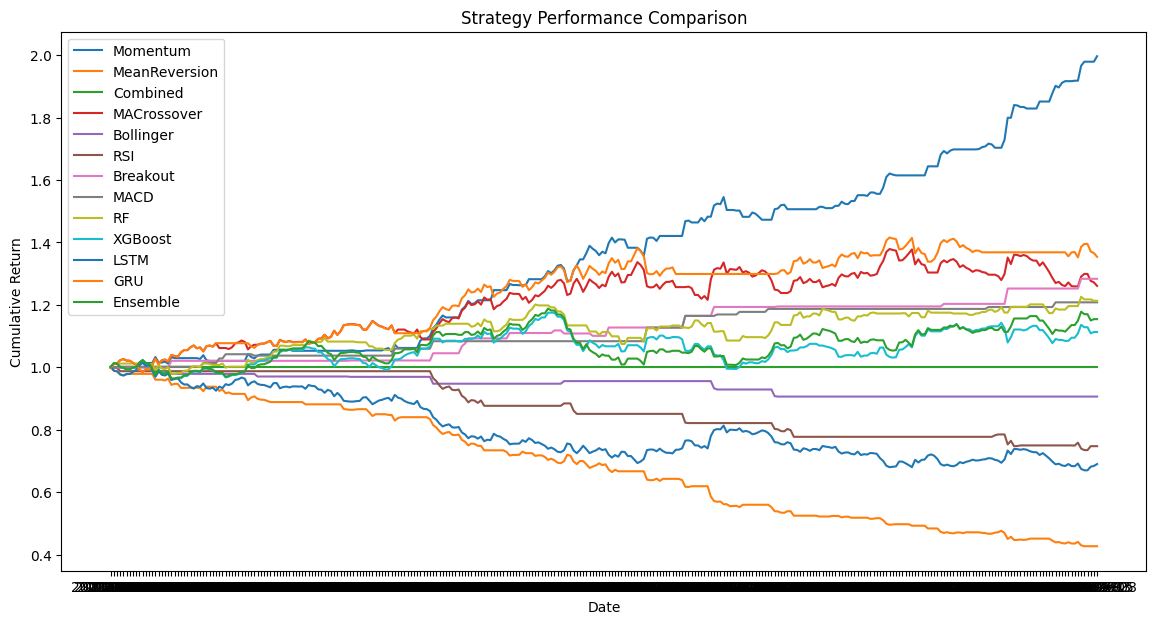

In [240]:
# Plot Cumulative Returns
plt.figure(figsize=(14, 7))

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    plt.plot(test_df['Date'], test_df[f'Cumulative_Return_{strategy}'], label=strategy)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Performance Comparison')
plt.legend()
plt.show()


# Including Transaction Costs

In [241]:
commission_rate = 0.005  # 0.5%

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    test_df[f'Transaction_Cost_{strategy}'] = commission_rate * abs(test_df[f'Signal_{strategy}'].diff()) * test_df['Open']
    test_df[f'Transaction_Cost_{strategy}'].fillna(0, inplace=True)
    test_df[f'Net_Return_{strategy}'] = test_df[f'Return_{strategy}'] - test_df[f'Transaction_Cost_{strategy}'] / test_df['Open']
    
    # Recalculate cumulative net returns
    test_df[f'Cumulative_Net_Return_{strategy}'] = (1 + test_df[f'Net_Return_{strategy}'].fillna(0)).cumprod()


In [242]:
for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    # Recalculate performance metrics with net returns
    total_return = test_df[f'Cumulative_Net_Return_{strategy}'].iloc[-1] - 1
    num_days = len(test_df)
    annualized_return = (1 + total_return) ** (252 / num_days) - 1
    daily_return = test_df[f'Net_Return_{strategy}'].fillna(0)
    sharpe_ratio = daily_return.mean() / daily_return.std() * np.sqrt(252) if daily_return.std() != 0 else 0
    
    # Update performance DataFrame
    performance.loc[strategy, 'Total Return (Net)'] = total_return
    performance.loc[strategy, 'Annualized Return (Net)'] = annualized_return
    performance.loc[strategy, 'Sharpe Ratio (Net)'] = sharpe_ratio

print("Performance Metrics with Transaction Costs:")
print(performance[['Total Return (Net)', 'Annualized Return (Net)', 'Sharpe Ratio (Net)']])


Performance Metrics with Transaction Costs:
               Total Return (Net)  Annualized Return (Net)  Sharpe Ratio (Net)
Momentum                 0.231274                 0.184267            1.392608
MeanReversion           -0.704478                -0.628772           -6.422757
Combined                 0.000000                 0.000000            0.000000
MACrossover              0.152527                 0.122319            0.734068
Bollinger               -0.155439                -0.128318           -2.575904
RSI                     -0.317391                -0.266841           -3.237244
Breakout                 0.105646                 0.085065            1.288272
MACD                     0.040540                 0.032832            0.641123
RF                      -0.522339                -0.451527           -4.391667
XGBoost                 -0.654023                -0.578021           -5.104897
LSTM                    -0.309702                -0.260135           -1.549625
GRU     

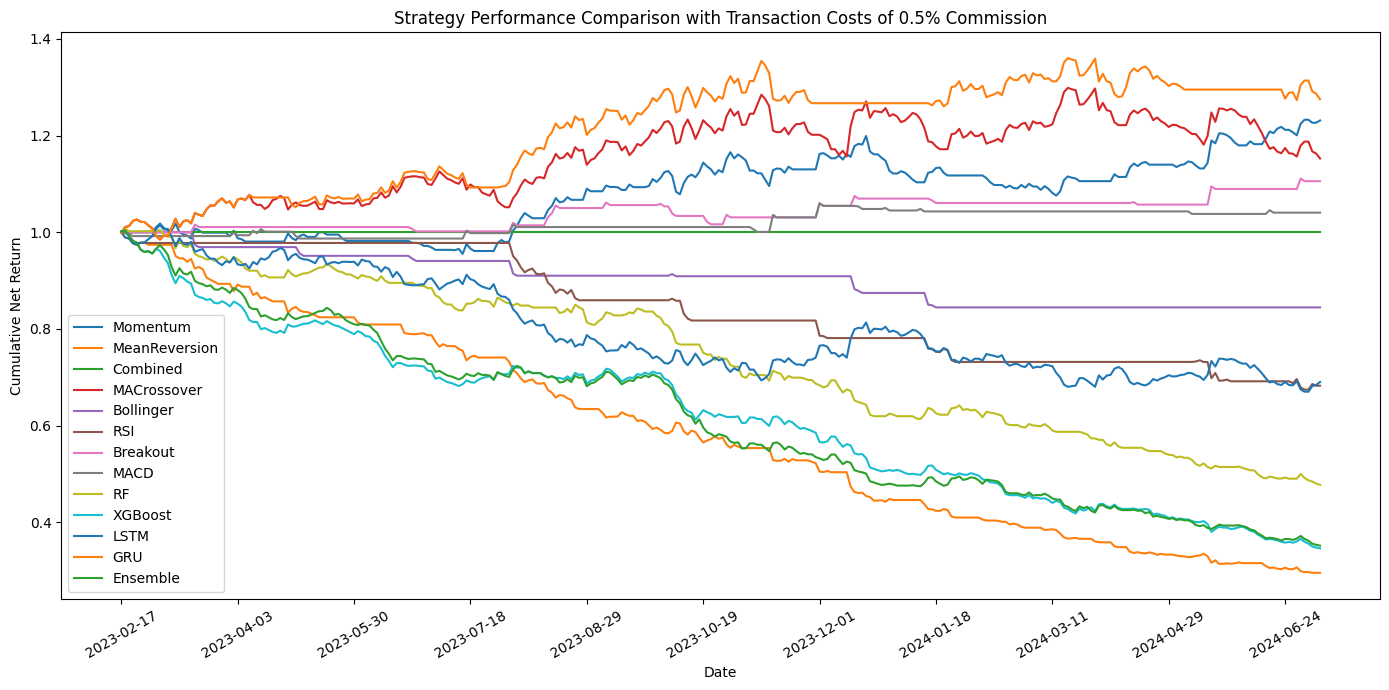

In [243]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for strategy in strategies:
    if f'Return_{strategy}' not in test_df.columns:
        continue
    plt.plot(test_df['Date'], test_df[f'Cumulative_Net_Return_{strategy}'], label=strategy)

# Manually set x-axis tick locations every 30 days
tick_locs = test_df['Date'][::30]
plt.gca().set_xticks(tick_locs) 

# Optionally format tick labels
# plt.gca().set_xticklabels(tick_locs.dt.strftime('%Y-%m'), rotation=45)

plt.xlabel('Date')
plt.ylabel('Cumulative Net Return')
plt.title(f'Strategy Performance Comparison with Transaction Costs of {commission_rate * 100}% Commission')
plt.legend()

plt.xticks(rotation=30)  
plt.tight_layout()  
plt.show()
